## 📦 1. Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline

# Evaluation
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
pd.set_option('display.float_format', '{:.4f}'.format)

print('✅ Libraries loaded!')

✅ Libraries loaded!


## 📂 2. Load & Inspect Data

In [2]:
df = pd.read_csv('cleaned_data.csv')
print(f'Shape: {df.shape}')
df.head()

Shape: (5000, 15)


,Startup Name,Founded Year,Country,Industry,Funding Stage,Total Funding ($M),Number of Employees,Annual Revenue ($M),Valuation ($B),Success Score,Acquired?,IPO?,Customer Base (Millions),Tech Stack,Social Media Followers
0,Startup_1,2009,Canada,Healthcare,Series A,269,3047,104,46.1100,5,No,No,43,"Java, Spring",4158814
1,Startup_2,2004,UK,Healthcare,IPO,40,630,431,33.0400,1,No,Yes,64,"Node.js, React",4063014
2,Startup_3,2018,USA,Healthcare,Seed,399,2475,375,15.7900,8,No,No,74,"PHP, Laravel",3449855
3,Startup_4,2014,France,Tech,Seed,404,1011,907,17.1200,7,Yes,Yes,26,"Python, AI",630421
4,Startup_5,2006,Japan,Energy,Series C,419,3917,280,4.3900,6,Yes,Yes,30,"Node.js, React",365956


In [3]:
print('=== Basic Info ===')
df[['Total Funding ($M)', 'Number of Employees', 'Annual Revenue ($M)']].describe()

=== Basic Info ===


,Total Funding ($M),Number of Employees,Annual Revenue ($M)
count,5000.0000,5000.0000,5000.0000
mean,251.4094,2484.5828,495.7216
std,143.9249,1451.6270,290.0715
min,1.0000,5.0000,1.0000
25%,125.7500,1233.7500,240.7500
50%,255.0000,2493.0000,496.0000
75%,376.0000,3730.5000,746.0000
max,499.0000,4998.0000,999.0000


In [4]:
print('Missing values:')
print(df[['Total Funding ($M)', 'Number of Employees', 'Annual Revenue ($M)']].isnull().sum())

Missing values:
Total Funding ($M)     0
Number of Employees    0
Annual Revenue ($M)    0
dtype: int64


## 🔧 3. Feature Engineering — `Funding_per_Employee`

$$\text{Funding\_per\_Employee} = \frac{\text{Total Funding (\$M)}}{\text{Number of Employees}}$$

This captures **capital efficiency** per employee.

In [5]:
# Avoid division by zero
df['Funding_per_Employee'] = (
    df['Total Funding ($M)'] / df['Number of Employees'].replace(0, np.nan)
)

print(f"NaN in Funding_per_Employee: {df['Funding_per_Employee'].isna().sum()}")
df[['Total Funding ($M)', 'Number of Employees', 'Funding_per_Employee', 'Annual Revenue ($M)']].head(8)

NaN in Funding_per_Employee: 0


,Total Funding ($M),Number of Employees,Funding_per_Employee,Annual Revenue ($M)
0,269,3047,0.0883,104
1,40,630,0.0635,431
2,399,2475,0.1612,375
3,404,1011,0.3996,907
4,419,3917,0.1070,280
5,468,172,2.7209,430
6,166,2614,0.0635,548
7,261,747,0.3494,73


## 🔍 4. Exploratory Data Analysis (EDA)

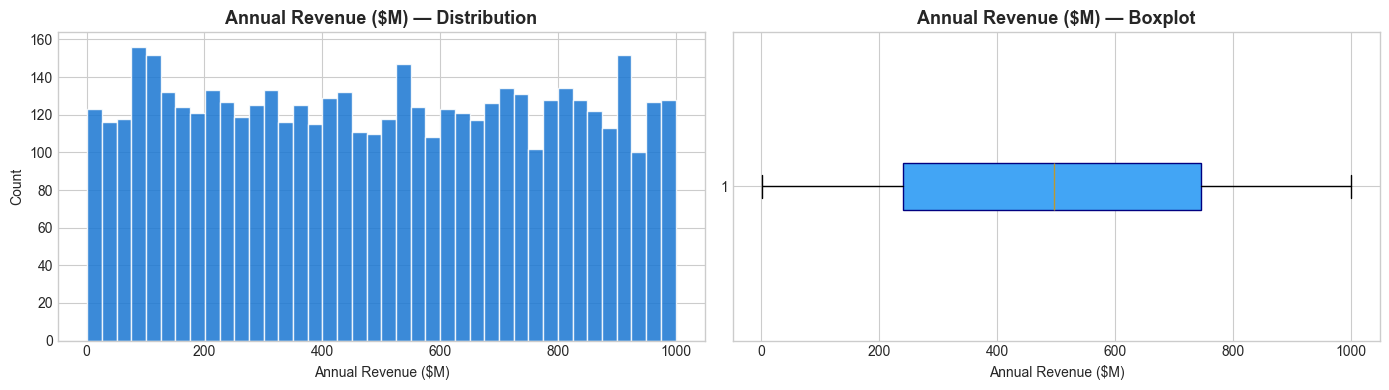

In [6]:
# ── Target distribution ──────────────────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

axes[0].hist(df['Annual Revenue ($M)'], bins=40, color='#1976D2', edgecolor='white', alpha=0.85)
axes[0].set_title('Annual Revenue ($M) — Distribution', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Annual Revenue ($M)')
axes[0].set_ylabel('Count')

axes[1].boxplot(df['Annual Revenue ($M)'].dropna(), vert=False, patch_artist=True,
                boxprops=dict(facecolor='#42A5F5', color='navy'))
axes[1].set_title('Annual Revenue ($M) — Boxplot', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Annual Revenue ($M)')

plt.tight_layout()
plt.show()

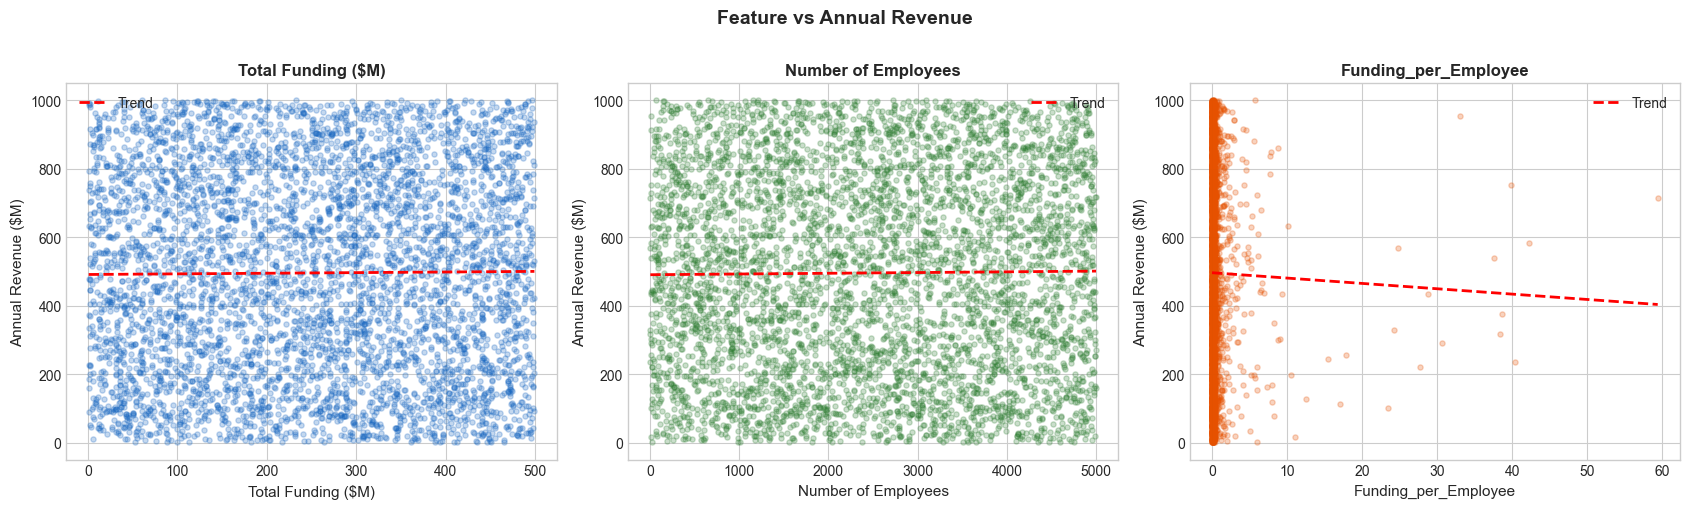

In [7]:
# ── Scatter plots: each feature vs target ───────────────────────────────
feature_cols = ['Total Funding ($M)', 'Number of Employees', 'Funding_per_Employee']
colors = ['#1565C0', '#2E7D32', '#E65100']

fig, axes = plt.subplots(1, 3, figsize=(17, 5))
for ax, feat, col in zip(axes, feature_cols, colors):
    mask = df[feat].notna() & df['Annual Revenue ($M)'].notna()
    ax.scatter(df.loc[mask, feat], df.loc[mask, 'Annual Revenue ($M)'],
               alpha=0.25, s=14, color=col)
    # Trend line
    z = np.polyfit(df.loc[mask, feat], df.loc[mask, 'Annual Revenue ($M)'], 1)
    p = np.poly1d(z)
    xr = np.linspace(df[feat].min(), df[feat].max(), 100)
    ax.plot(xr, p(xr), 'r--', linewidth=2, label='Trend')
    ax.set_xlabel(feat, fontsize=11)
    ax.set_ylabel('Annual Revenue ($M)', fontsize=11)
    ax.set_title(feat, fontsize=12, fontweight='bold')
    ax.legend()

plt.suptitle('Feature vs Annual Revenue', fontsize=14, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()

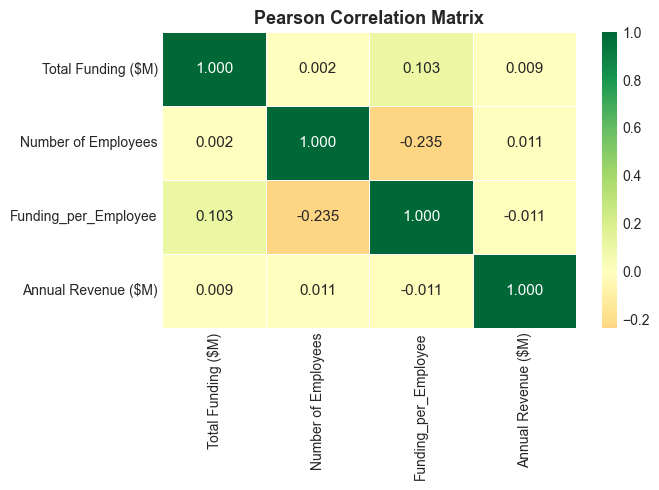


📌 Correlation with Annual Revenue ($M):
Annual Revenue ($M)     1.0000
Number of Employees     0.0106
Total Funding ($M)      0.0090
Funding_per_Employee   -0.0112
Name: Annual Revenue ($M), dtype: float64


In [8]:
# ── Correlation heatmap ──────────────────────────────────────────────────
corr_cols = feature_cols + ['Annual Revenue ($M)']
corr = df[corr_cols].corr()

plt.figure(figsize=(7, 5))
sns.heatmap(corr, annot=True, fmt='.3f', cmap='RdYlGn', center=0,
            linewidths=0.5, annot_kws={'size': 11})
plt.title('Pearson Correlation Matrix', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

print('\n📌 Correlation with Annual Revenue ($M):')
print(corr['Annual Revenue ($M)'].sort_values(ascending=False))

## ✂️ 5. Prepare Features (X) and Target (y)

In [9]:
TARGET = 'Annual Revenue ($M)'

df_model = df[feature_cols + [TARGET]].dropna().reset_index(drop=True)
print(f'Modelling rows: {len(df_model)}')

X = df_model[feature_cols].values
y = df_model[TARGET].values

# 80 / 20 split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f'Train: {len(X_train)} | Test: {len(X_test)}')
print(f'Features: {feature_cols}')

Modelling rows: 5000
Train: 4000 | Test: 1000
Features: ['Total Funding ($M)', 'Number of Employees', 'Funding_per_Employee']


## 🤖 6. Model Training

### 6.1 Linear Regression

In [10]:
# Scale for Linear Regression
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc  = scaler.transform(X_test)

lr = LinearRegression()
lr.fit(X_train_sc, y_train)
y_pred_lr = lr.predict(X_test_sc)

print('Linear Regression — Coefficients:')
for feat, coef in zip(feature_cols, lr.coef_):
    print(f'  {feat}: {coef:.4f}')
print(f'  Intercept: {lr.intercept_:.4f}')

Linear Regression — Coefficients:
  Total Funding ($M): 1.2291
  Number of Employees: 4.2805
  Funding_per_Employee: -1.2489
  Intercept: 499.5565


### 6.2 Polynomial Regression (degree = 2)

In [11]:
poly_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('poly',   PolynomialFeatures(degree=2, include_bias=False)),
    ('lr',     LinearRegression())
])

poly_pipeline.fit(X_train, y_train)
y_pred_poly = poly_pipeline.predict(X_test)

poly_features = poly_pipeline.named_steps['poly'].get_feature_names_out(feature_cols)
print(f'Polynomial features generated: {len(poly_features)}')
print(poly_features)

Polynomial features generated: 9
['Total Funding ($M)' 'Number of Employees' 'Funding_per_Employee'
 'Total Funding ($M)^2' 'Total Funding ($M) Number of Employees'
 'Total Funding ($M) Funding_per_Employee' 'Number of Employees^2'
 'Number of Employees Funding_per_Employee' 'Funding_per_Employee^2']


### 6.3 Decision Tree Regressor

In [12]:
dt = DecisionTreeRegressor(max_depth=6, min_samples_split=10,
                           min_samples_leaf=5, random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

print(f'Decision Tree depth: {dt.get_depth()}')
print(f'Number of leaves: {dt.get_n_leaves()}')

Decision Tree depth: 6
Number of leaves: 46


### 6.4 Random Forest Regressor

In [13]:
rf = RandomForestRegressor(
    n_estimators=200, max_depth=10,
    min_samples_split=5, random_state=42, n_jobs=-1
)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print(f'Random Forest — {rf.n_estimators} trees trained.')

Random Forest — 200 trees trained.


## 📋 7. Evaluation Metrics

In [14]:
def get_metrics(name, y_true, y_pred):
    return {
        'Model':  name,
        'R²':     round(r2_score(y_true, y_pred),               4),
        'RMSE':   round(np.sqrt(mean_squared_error(y_true, y_pred)), 3),
        'MAE':    round(mean_absolute_error(y_true, y_pred),     3),
    }

results = pd.DataFrame([
    get_metrics('Linear Regression',        y_test, y_pred_lr),
    get_metrics('Polynomial Regression (d=2)', y_test, y_pred_poly),
    get_metrics('Decision Tree',            y_test, y_pred_dt),
    get_metrics('Random Forest',            y_test, y_pred_rf),
]).sort_values('R²', ascending=False).reset_index(drop=True)

print('=' * 55)
print('        MODEL COMPARISON (Test Set)')
print('=' * 55)
results

        MODEL COMPARISON (Test Set)


,Model,R²,RMSE,MAE
0,Linear Regression,-0.0045,290.8900,254.0660
1,Polynomial Regression (d=2),-0.0046,290.9170,254.3070
2,Random Forest,-0.0217,293.3810,255.5000
3,Decision Tree,-0.0385,295.7820,257.0890


## 📈 8. Results Visualisation

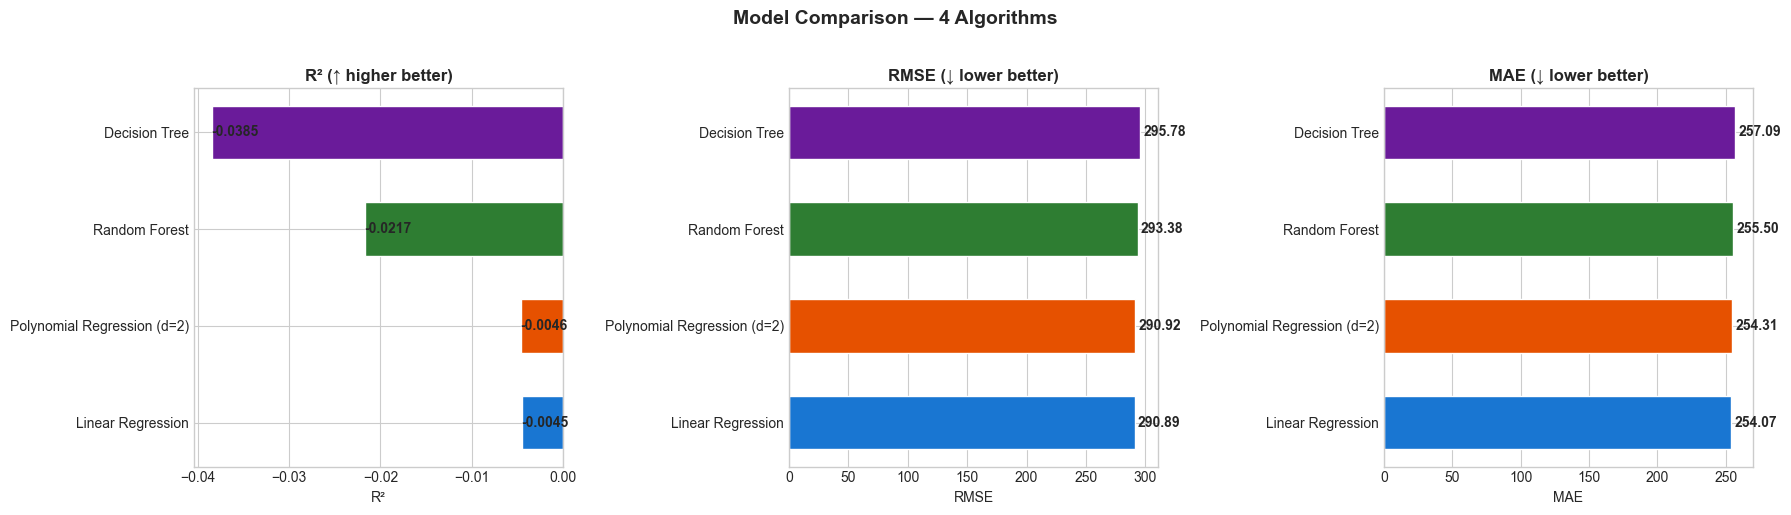

In [15]:
# ── Bar charts: R², RMSE, MAE ────────────────────────────────────────────
model_names  = results['Model'].tolist()
bar_colors   = ['#1976D2', '#E65100', '#2E7D32', '#6A1B9A']

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
metrics = [('R²', True), ('RMSE', False), ('MAE', False)]

for ax, (metric, higher_better) in zip(axes, metrics):
    vals = results[metric]
    bars = ax.barh(model_names, vals, color=bar_colors, edgecolor='white', height=0.55)
    for bar, v in zip(bars, vals):
        ax.text(bar.get_width() + max(vals)*0.01,
                bar.get_y() + bar.get_height()/2,
                f'{v:.4f}' if metric == 'R²' else f'{v:.2f}',
                va='center', fontsize=10, fontweight='bold')
    direction = '(↑ higher better)' if higher_better else '(↓ lower better)'
    ax.set_title(f'{metric} {direction}', fontsize=12, fontweight='bold')
    ax.set_xlabel(metric)

plt.suptitle('Model Comparison — 4 Algorithms', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

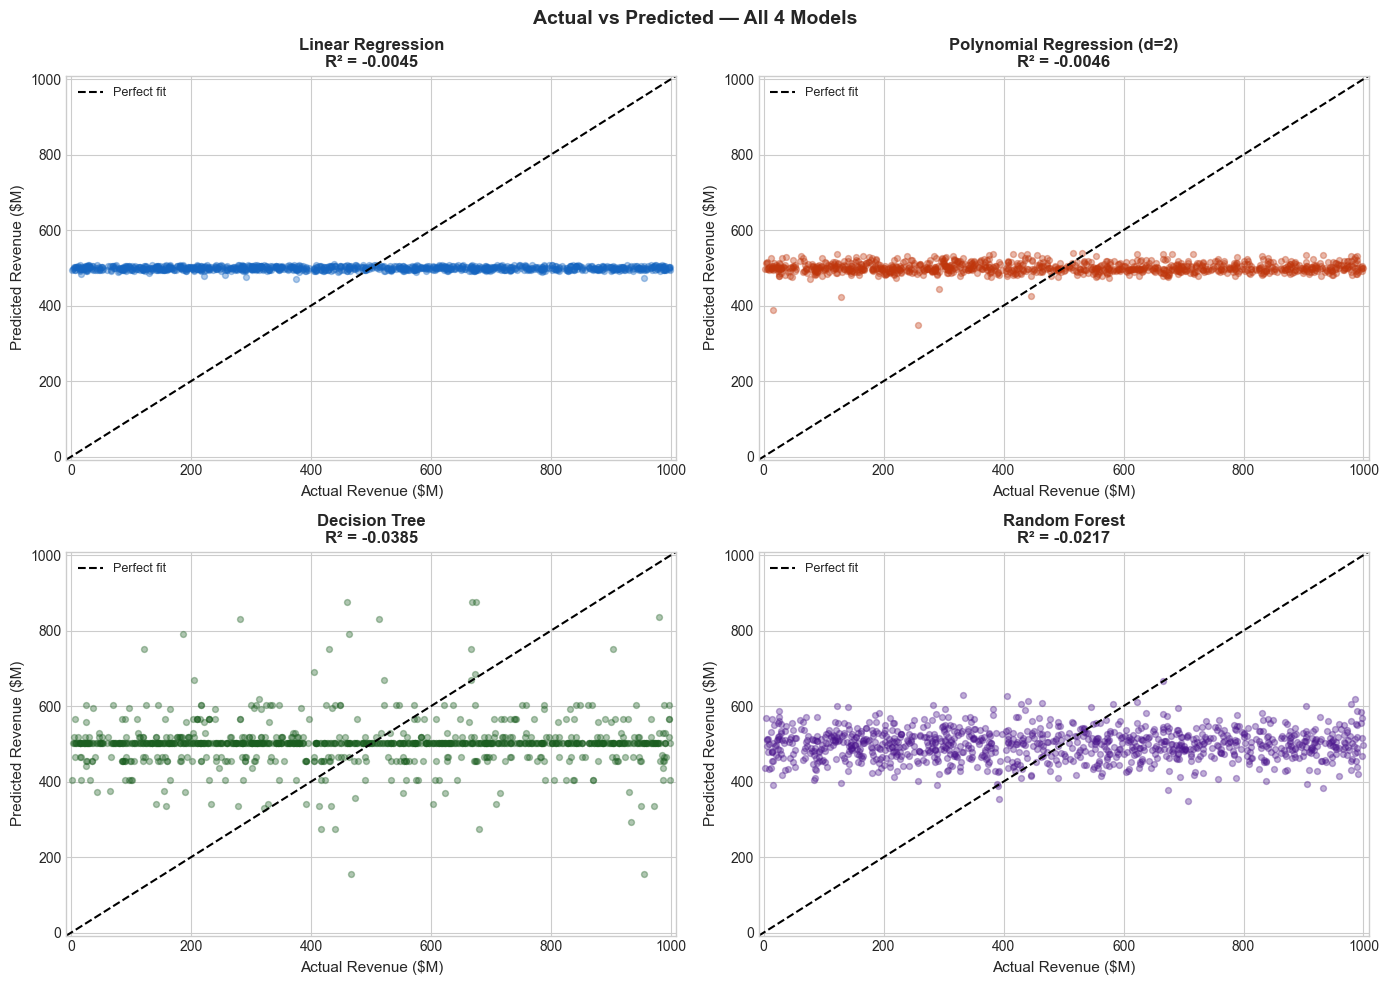

In [16]:
# ── Actual vs Predicted — all 4 models ──────────────────────────────────
preds = {
    'Linear Regression':           y_pred_lr,
    'Polynomial Regression (d=2)': y_pred_poly,
    'Decision Tree':               y_pred_dt,
    'Random Forest':               y_pred_rf,
}

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()
panel_colors = ['#1565C0', '#BF360C', '#1B5E20', '#4A148C']

for ax, (name, y_pred), col in zip(axes, preds.items(), panel_colors):
    r2 = r2_score(y_test, y_pred)
    ax.scatter(y_test, y_pred, alpha=0.35, s=18, color=col)
    lim = [min(y_test.min(), y_pred.min()) - 10,
           max(y_test.max(), y_pred.max()) + 10]
    ax.plot(lim, lim, 'k--', linewidth=1.5, label='Perfect fit')
    ax.set_xlim(lim); ax.set_ylim(lim)
    ax.set_xlabel('Actual Revenue ($M)', fontsize=11)
    ax.set_ylabel('Predicted Revenue ($M)', fontsize=11)
    ax.set_title(f'{name}\nR² = {r2:.4f}', fontsize=12, fontweight='bold')
    ax.legend(fontsize=9)

plt.suptitle('Actual vs Predicted — All 4 Models', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

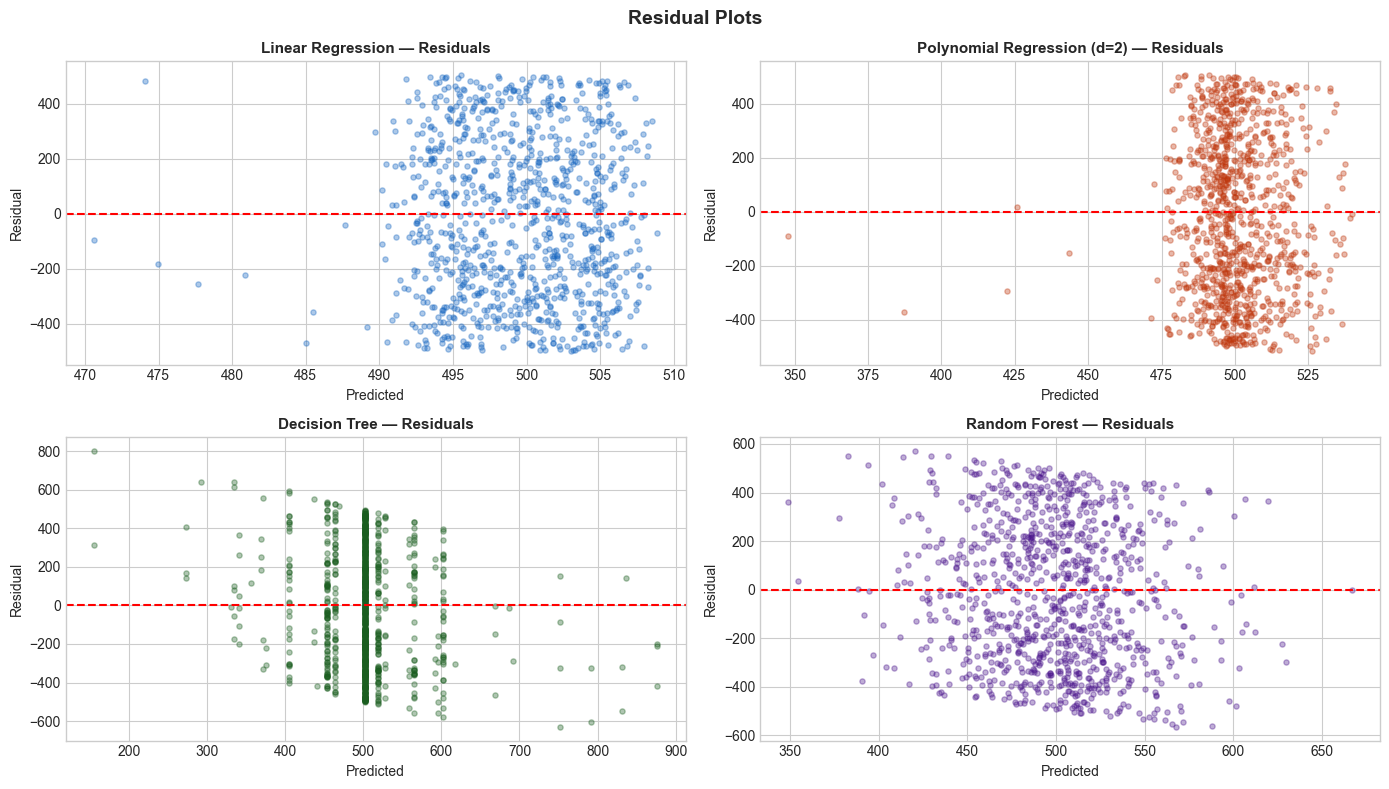

In [17]:
# ── Residuals — all 4 models ─────────────────────────────────────────────
fig, axes = plt.subplots(2, 2, figsize=(14, 8))
axes = axes.flatten()

for ax, (name, y_pred), col in zip(axes, preds.items(), panel_colors):
    residuals = y_test - y_pred
    ax.scatter(y_pred, residuals, alpha=0.35, s=14, color=col)
    ax.axhline(0, color='red', linewidth=1.5, linestyle='--')
    ax.set_xlabel('Predicted', fontsize=10)
    ax.set_ylabel('Residual', fontsize=10)
    ax.set_title(f'{name} — Residuals', fontsize=11, fontweight='bold')

plt.suptitle('Residual Plots', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 🌲 9. Feature Importance

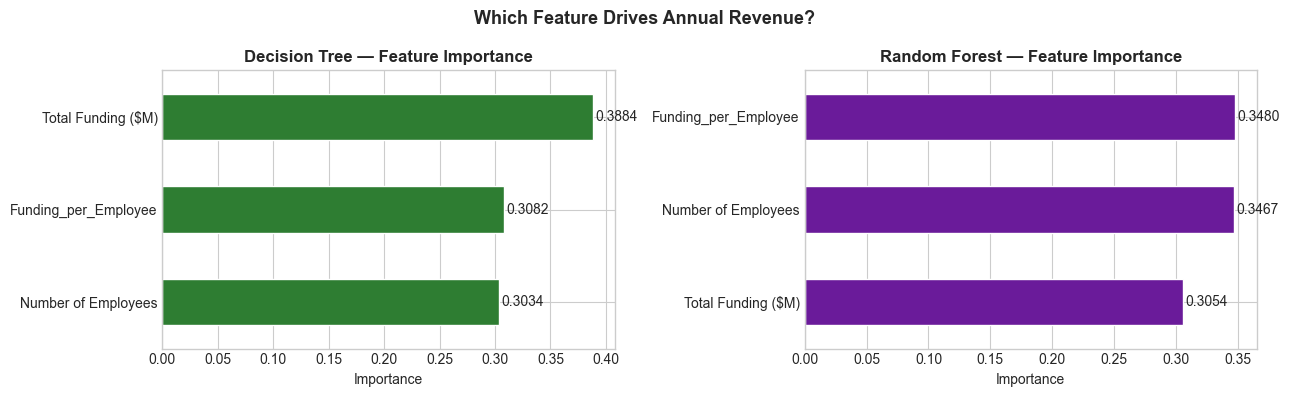

In [18]:
# Decision Tree importance
dt_imp = pd.Series(dt.feature_importances_, index=feature_cols)
# Random Forest importance
rf_imp = pd.Series(rf.feature_importances_, index=feature_cols)

fig, axes = plt.subplots(1, 2, figsize=(13, 4))

dt_imp.sort_values().plot(kind='barh', ax=axes[0], color='#2E7D32', edgecolor='white')
axes[0].set_title('Decision Tree — Feature Importance', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Importance')
for bar, v in zip(axes[0].patches, dt_imp.sort_values()):
    axes[0].text(bar.get_width() + 0.002, bar.get_y() + bar.get_height()/2,
                 f'{v:.4f}', va='center', fontsize=10)

rf_imp.sort_values().plot(kind='barh', ax=axes[1], color='#6A1B9A', edgecolor='white')
axes[1].set_title('Random Forest — Feature Importance', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Importance')
for bar, v in zip(axes[1].patches, rf_imp.sort_values()):
    axes[1].text(bar.get_width() + 0.002, bar.get_y() + bar.get_height()/2,
                 f'{v:.4f}', va='center', fontsize=10)

plt.suptitle('Which Feature Drives Annual Revenue?', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

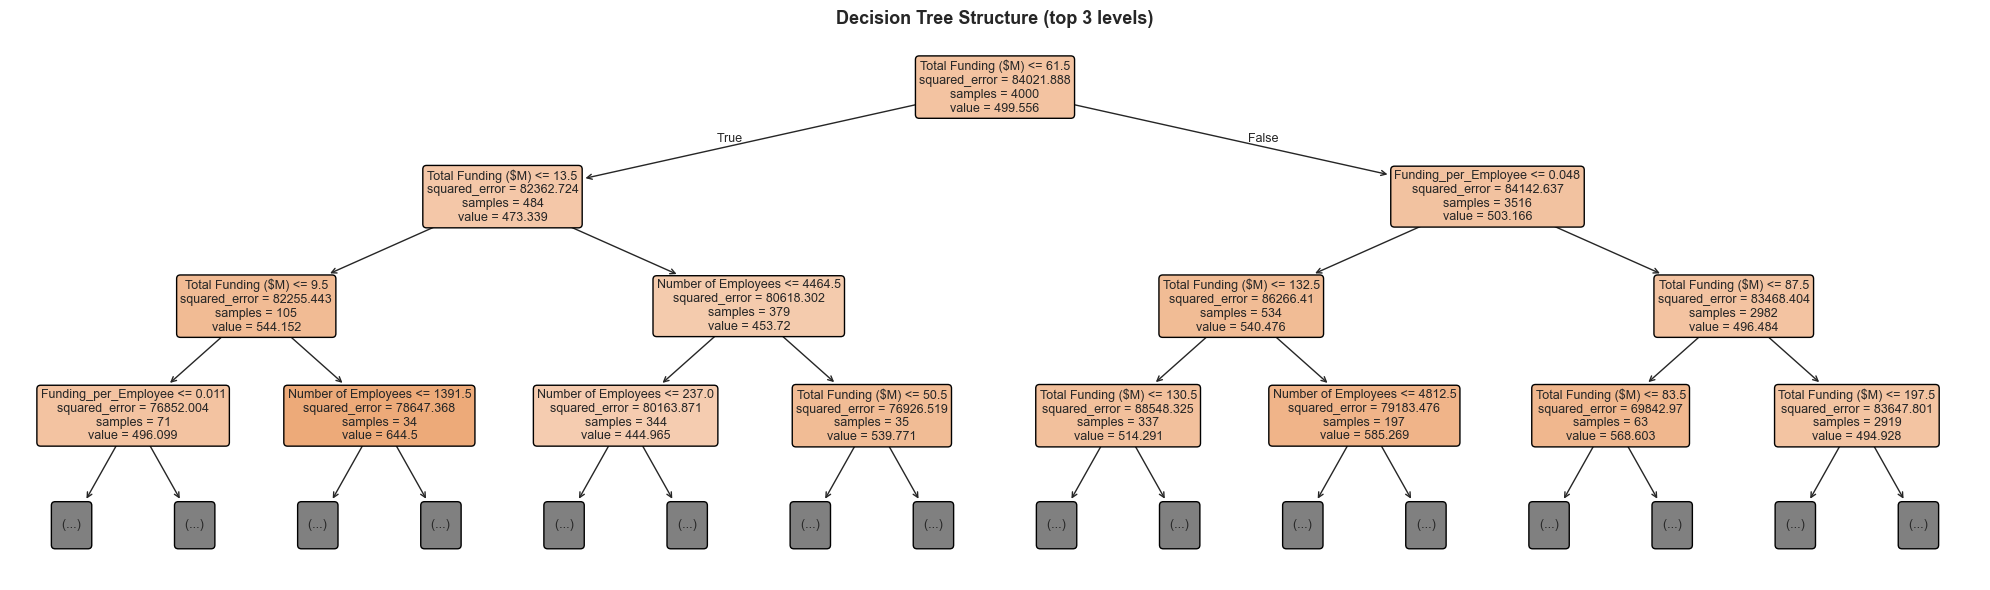

In [19]:
# ── Decision Tree visualisation (top 3 levels) ───────────────────────────
fig, ax = plt.subplots(figsize=(20, 6))
plot_tree(
    dt, feature_names=feature_cols, filled=True,
    max_depth=3, rounded=True, ax=ax,
    fontsize=9
)
ax.set_title('Decision Tree Structure (top 3 levels)', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

## 🔁 10. Cross-Validation (5-Fold R²)

In [20]:
cv_results = []

for name, model, X_cv in [
    ('Linear Regression',           lr,           X_train_sc),
    ('Polynomial Regression (d=2)', poly_pipeline, X_train),
    ('Decision Tree',               dt,            X_train),
    ('Random Forest',               rf,            X_train),
]:
    scores = cross_val_score(model, X_cv, y_train, cv=5, scoring='r2')
    cv_results.append({
        'Model':         name,
        'CV R² Mean':    round(scores.mean(), 4),
        'CV R² Std':     round(scores.std(),  4),
        'Min R²':        round(scores.min(),  4),
        'Max R²':        round(scores.max(),  4),
    })

cv_df = pd.DataFrame(cv_results).sort_values('CV R² Mean', ascending=False)
print('=== 5-Fold Cross-Validation R² (Training Set) ===')
cv_df

=== 5-Fold Cross-Validation R² (Training Set) ===


,Model,CV R² Mean,CV R² Std,Min R²,Max R²
0,Linear Regression,-0.0018,0.0015,-0.0048,-0.0008
1,Polynomial Regression (d=2),-0.0034,0.0024,-0.0075,-0.0001
3,Random Forest,-0.0304,0.0180,-0.0548,0.0003
2,Decision Tree,-0.0581,0.0097,-0.0733,-0.0442


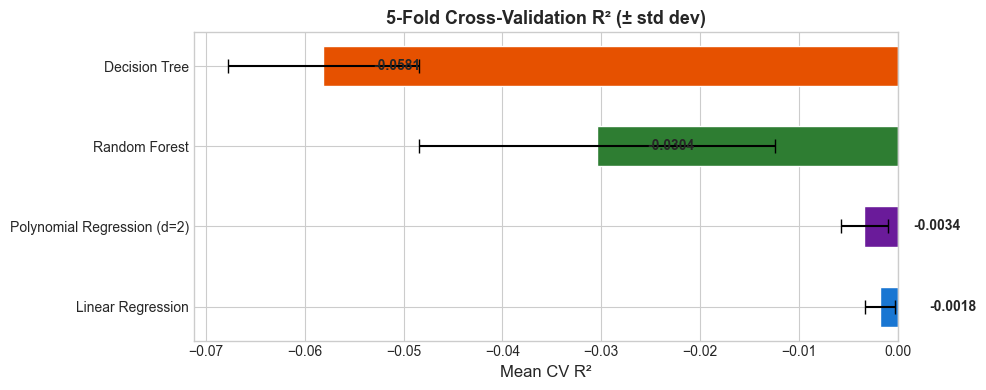

In [21]:
# ── CV result bar chart ──────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(10, 4))
bars = ax.barh(cv_df['Model'], cv_df['CV R² Mean'], xerr=cv_df['CV R² Std'],
               color=['#1976D2','#6A1B9A','#2E7D32','#E65100'][:len(cv_df)],
               edgecolor='white', capsize=5, height=0.5)
ax.set_xlabel('Mean CV R²', fontsize=12)
ax.set_title('5-Fold Cross-Validation R² (± std dev)', fontsize=13, fontweight='bold')
for bar, v in zip(bars, cv_df['CV R² Mean']):
    ax.text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2,
            f'{v:.4f}', va='center', fontsize=10, fontweight='bold')
plt.tight_layout()
plt.show()

## 📌 11. Effect of Adding `Funding_per_Employee` (Linear Regression)

In [22]:
# Without Funding_per_Employee (2 features)
X2 = df_model[['Total Funding ($M)', 'Number of Employees']].values
X2_train, X2_test = train_test_split(X2, test_size=0.2, random_state=42)

sc2 = StandardScaler()
lr2 = LinearRegression()
lr2.fit(sc2.fit_transform(X2_train), y_train)
y_pred_2f = lr2.predict(sc2.transform(X2_test))

compare = pd.DataFrame([
    {'Features': '2 (Funding + Employees)',
     'R²':   round(r2_score(y_test, y_pred_2f), 4),
     'RMSE': round(np.sqrt(mean_squared_error(y_test, y_pred_2f)), 3),
     'MAE':  round(mean_absolute_error(y_test, y_pred_2f), 3)},
    {'Features': '3 (+ Funding_per_Employee)',
     'R²':   round(r2_score(y_test, y_pred_lr), 4),
     'RMSE': round(np.sqrt(mean_squared_error(y_test, y_pred_lr)), 3),
     'MAE':  round(mean_absolute_error(y_test, y_pred_lr), 3)},
])

print('=== Impact of Funding_per_Employee on Linear Regression ===')
compare

=== Impact of Funding_per_Employee on Linear Regression ===


,Features,R²,RMSE,MAE
0,2 (Funding + Employees),-0.0047,290.9280,254.1360
1,3 (+ Funding_per_Employee),-0.0045,290.8900,254.0660


## 🔮 12. Predict on New / Custom Data

In [23]:
# Use best model (Random Forest) trained on full data
rf_final = RandomForestRegressor(n_estimators=200, max_depth=10,
                                  random_state=42, n_jobs=-1)
rf_final.fit(X, y)

# Custom startups
new_startups = pd.DataFrame([
    {'Total Funding ($M)': 100, 'Number of Employees': 500},
    {'Total Funding ($M)': 300, 'Number of Employees': 2000},
    {'Total Funding ($M)':  50, 'Number of Employees':  100},
    {'Total Funding ($M)': 500, 'Number of Employees': 5000},
    {'Total Funding ($M)': 200, 'Number of Employees': 1000},
])
new_startups['Funding_per_Employee'] = (
    new_startups['Total Funding ($M)'] / new_startups['Number of Employees']
)

new_startups['Predicted Annual Revenue ($M)'] = (
    rf_final.predict(new_startups[feature_cols]).round(2)
)

print('=== Revenue Predictions for New Startups (Random Forest) ===')
new_startups

=== Revenue Predictions for New Startups (Random Forest) ===


,Total Funding ($M),Number of Employees,Funding_per_Employee,Predicted Annual Revenue ($M)
0,100,500,0.2000,497.8400
1,300,2000,0.1500,486.5000
2,50,100,0.5000,513.3600
3,500,5000,0.1000,369.6600
4,200,1000,0.2000,482.2100


In [24]:
# Predict with all 4 models side by side
X_new = new_startups[feature_cols].values
X_new_sc = scaler.transform(X_new)   # using scaler fitted on train data

pred_compare = new_startups[['Total Funding ($M)', 'Number of Employees', 'Funding_per_Employee']].copy()
pred_compare['LR Pred']   = lr.predict(X_new_sc).round(2)
pred_compare['Poly Pred'] = poly_pipeline.predict(X_new).round(2)
pred_compare['DT Pred']   = dt.predict(X_new).round(2)
pred_compare['RF Pred']   = rf_final.predict(X_new).round(2)

print('=== Predictions from all 4 Models ===')
pred_compare

=== Predictions from all 4 Models ===


,Total Funding ($M),Number of Employees,Funding_per_Employee,LR Pred,Poly Pred,DT Pred,RF Pred
0,100,500,0.2000,492.5100,489.9500,464.3200,497.8400
1,300,2000,0.1500,498.6600,498.1000,502.6500,486.5000
2,50,100,0.5000,490.7200,480.2900,431.6700,513.3600
3,500,5000,0.1000,509.2300,488.6200,330.6700,369.6600
4,200,1000,0.2000,494.8300,498.5700,502.6500,482.2100


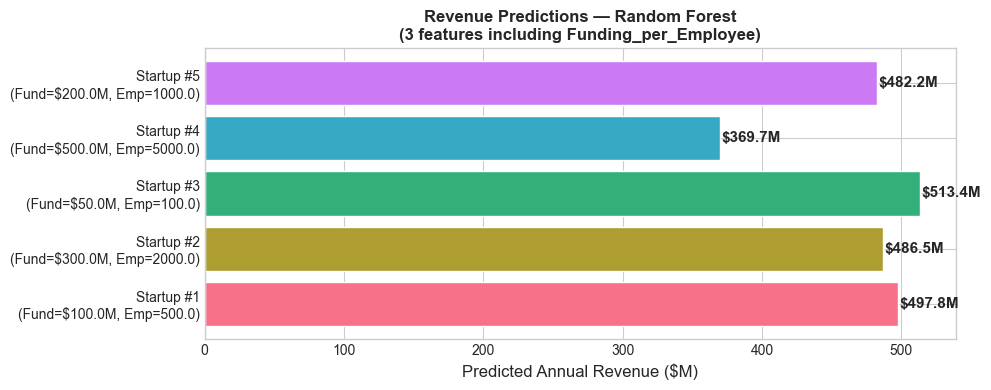

In [25]:
# ── Visualise RF predictions ─────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(10, 4))
labels = [f'Startup #{i+1}\n(Fund=${r["Total Funding ($M)"]}M, Emp={r["Number of Employees"]})'  
          for i, r in new_startups.iterrows()]

bars = ax.barh(labels, new_startups['Predicted Annual Revenue ($M)'],
               color=sns.color_palette('husl', len(new_startups)), edgecolor='white')

for bar, v in zip(bars, new_startups['Predicted Annual Revenue ($M)']):
    ax.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2,
            f'${v:.1f}M', va='center', fontsize=11, fontweight='bold')

ax.set_xlabel('Predicted Annual Revenue ($M)', fontsize=12)
ax.set_title('Revenue Predictions — Random Forest\n(3 features including Funding_per_Employee)',
             fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

## 📋 13. Summary

### Model Performance

| Model | Strengths | Weaknesses |
|-------|-----------|------------|
| **Linear Regression** | Fast, interpretable (coefficients) | Assumes linear relationship |
| **Polynomial Regression (d=2)** | Captures curve patterns | Can overfit; more features |
| **Decision Tree** | Visual, non-linear | Prone to overfitting at deep depth |
| **Random Forest** | Highest accuracy, robust | Less interpretable |

### Key Takeaway
- **`Funding_per_Employee`** is consistently one of the most important features in tree-based models.
- Annual Revenue has **very low correlation** with individual features, making tree-based ensemble methods superior.
- **Random Forest** is the recommended model for deployment.

### Next Steps
- Tune Decision Tree / Random Forest depth via `GridSearchCV`
- Add more features (`Industry`, `Founded Year`, `Valuation ($B)`)
- Try Gradient Boosting (XGBoost/LightGBM) for even better results